Data Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
dataset_train.head()
training_set = dataset_train.iloc[:,1:2].values
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

Feature scaling


In [5]:
from sklearn.preprocessing import MinMaxScaler
minMax = MinMaxScaler(feature_range = (0,1))
training_set_scaled = minMax.fit_transform(training_set)




Next step is to decide how many time steps do we need our RNN to remember? 
60 time steps (so before predicting the next one it will take a look to 60 previous stock prices )
Output 1 = at time t +1

In [6]:
#1st train
X_train = []
y_train = []

for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i , 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
X_train

array([[0.08581368, 0.09701243, 0.09433366, ..., 0.07846566, 0.08034452,
        0.08497656],
       [0.09701243, 0.09433366, 0.09156187, ..., 0.08034452, 0.08497656,
        0.08627874],
       [0.09433366, 0.09156187, 0.07984225, ..., 0.08497656, 0.08627874,
        0.08471612],
       ...,
       [0.92106928, 0.92438053, 0.93048218, ..., 0.95475854, 0.95204256,
        0.95163331],
       [0.92438053, 0.93048218, 0.9299055 , ..., 0.95204256, 0.95163331,
        0.95725128],
       [0.93048218, 0.9299055 , 0.93113327, ..., 0.95163331, 0.95725128,
        0.93796041]])

Reshaping by adding more dimensionality to the above X_train and y_train.
At this moment we have open indicator. 
We can add more dimensionality 

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))

<h1>Building the RNN using LSTM</h1>
Stacked LSTM with some drop out regularisation to avoid overfitting

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Initialising the RNN

In [13]:
rnn = Sequential()



add layers (First LSTM layer and some dropout Regularisation)

In [14]:
rnn.add(LSTM(units = 50, return_sequences= True, input_shape= (X_train.shape[1], 1)))

In [15]:
rnn.add(Dropout(rate = 0.2)) #20% neurons will be ignored everytime iteration of training

2nd LSTM Layer

In [16]:
rnn.add(LSTM(units = 50, return_sequences= True))
rnn.add(Dropout(rate = 0.2))

3rd LSTM Layer

In [17]:
rnn.add(LSTM(units = 50, return_sequences= True ))
rnn.add(Dropout(rate = 0.2))

4th LSTM layer

In [18]:
rnn.add(LSTM(units = 50))
rnn.add(Dropout(rate = 0.2))

Adding the output layer

In [19]:
rnn.add(Dense(units = 1)) #Stock price at time t + 1

Compiling the RNN

In [20]:
rnn.compile(optimizer='adam', loss ='mean_squared_error')

Fit to training set

In [21]:
rnn.fit(X_train, y_train, batch_size= 32 , epochs= 100 )

Epoch 1/100
38/38 [==============================] - 7s 52ms/step - loss: 0.0454
Epoch 2/100
38/38 [==============================] - 2s 53ms/step - loss: 0.0067
Epoch 3/100
38/38 [==============================] - 2s 53ms/step - loss: 0.0058
Epoch 4/100
38/38 [==============================] - 2s 52ms/step - loss: 0.0055
Epoch 5/100
38/38 [==============================] - 2s 53ms/step - loss: 0.0055
Epoch 6/100
38/38 [==============================] - 2s 52ms/step - loss: 0.0049
Epoch 7/100
38/38 [==============================] - 2s 53ms/step - loss: 0.0048
Epoch 8/100
38/38 [==============================] - 2s 55ms/step - loss: 0.0046
Epoch 9/100
38/38 [==============================] - 2s 52ms/step - loss: 0.0047
Epoch 10/100
38/38 [==============================] - 2s 54ms/step - loss: 0.0045
Epoch 11/100
38/38 [==============================] - 2s 54ms/step - loss: 0.0051
Epoch 12/100
38/38 [==============================] - 2s 53ms/step - loss: 0.0044
Epoch 13/100
38/38 [=====

Predict January 2017 
Make the predictions and visualise the results
Get the real stock price

In [22]:
dataset_test   = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:,1:2].values

Get the predicted stock price of 2017
We trained the model based on previous 60.
So to predict for every day of January, we need the predict the prices based on the previous 60 days of the data.
This means we will need some concatenation from X_train and y_train
But remember with X_train and y_train we have the scaled values and if we are using it to predict the values, 
meaning we need the actual values to predict. So we cannot use the scaled data.

Can we use the original dataset_train and dataset_test then?


In [23]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']),axis=0)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60 : ].values

inputs = inputs.reshape(-1,1) #to avoid any format issues

inputs = minMax.transform(inputs)

#1st train
X_test = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

predicted_stock_price = rnn.predict(X_test)
#reverse the scaling
predicted_stock_price = minMax.inverse_transform(predicted_stock_price)


1/1 [==============================] - 1s 1s/step


In [24]:
predicted_stock_price

array([[781.5523 ],
       [778.9896 ],
       [778.807  ],
       [779.9896 ],
       [783.2088 ],
       [789.019  ],
       [794.89667],
       [798.0666 ],
       [798.9938 ],
       [798.72076],
       [798.0367 ],
       [797.2479 ],
       [796.6125 ],
       [796.7501 ],
       [797.5264 ],
       [801.65063],
       [808.4043 ],
       [816.1884 ],
       [821.2695 ],
       [818.73895]], dtype=float32)

We are not sure if these results are following the same trend. Lets visualise to see how far are we in predicting.

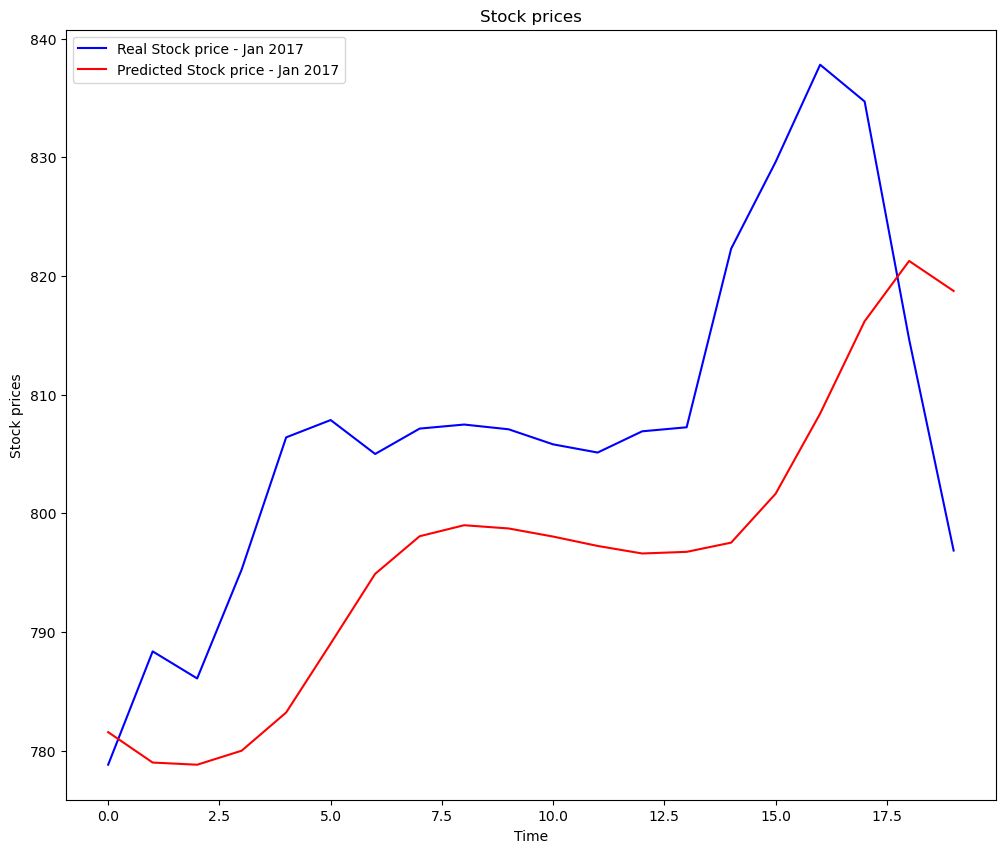

In [26]:
plt.figure(figsize=(12,10))
plt.plot(real_stock_price, color='blue', label="Real Stock price - Jan 2017")
plt.title("Stock prices")

plt.plot(predicted_stock_price, color='red', label="Predicted Stock price - Jan 2017")
plt.xlabel('Time')
plt.ylabel('Stock prices')
plt.legend()


